In [1]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [2]:
import sys
sys.path.insert(1, os.path.join(sys.path[0], '../'))

In [3]:
import torch
import torch.nn as nn
import torchvision

import math
from IPython.display import clear_output

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
from model import MaskedAutoencoder
import utils
from training import *

In [5]:
import random
import numpy as np

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True

In [6]:
unlabeled_dataset_name = 'cifar_10/train'         # ['stl_10/unlabeled', 'cifar_10/train']
test_dataset_name = 'cifar_10/test' 
config = get_pretrain_config(unlabeled_dataset_name)
print(config)

# Data config.
img_size = config['img_size']
in_channels = config['in_channels']
batch_size = config['batch_size']
patch_size = config['patch_size']
emb_dim = config['emb_dim']
mask_ratio = config['mask_ratio']
en_num_heads = config['en_num_heads']
en_depth = config['en_depth']
de_emb_dim = config['de_emb_dim']
de_num_heads = config['de_num_heads']
de_depth = config['de_depth']
use_norm_pix_loss = config['use_norm_pix_loss']
base_lr = config['base_lr']
weight_decay = config['weight_decay']
num_epochs = config['num_epochs']
warmup_epochs = config['warmup_epochs']
save_interval = config['save_interval']

pretrain_transform = get_pretrain_transform(img_size=img_size)

{'img_size': 32, 'in_channels': 3, 'batch_size': 256, 'patch_size': 2, 'emb_dim': 192, 'mask_ratio': 0.75, 'en_num_heads': 3, 'en_depth': 12, 'de_emb_dim': None, 'de_num_heads': 3, 'de_depth': 4, 'use_norm_pix_loss': True, 'base_lr': 0.00015, 'weight_decay': 0.05, 'num_epochs': 2000, 'warmup_epochs': 200, 'save_interval': 500}


In [7]:
unlabeled_data_dir = os.path.join('../datasets/', unlabeled_dataset_name)
unlabeled_dataset = UnlabeledImgDataset(unlabeled_data_dir, transform=pretrain_transform)
unlabeled_loader = torch.utils.data.DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

test_data_dir = os.path.join('../datasets/', test_dataset_name)
test_dataset = UnlabeledImgDataset(test_data_dir, transform=pretrain_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [8]:
save_dir = os.path.join('./output/', 'pretrain_{}'.format(unlabeled_dataset_name.replace('/', '_')))
os.makedirs(save_dir, exist_ok=True)
print(save_dir)

./output/pretrain_cifar_10_train


In [9]:
mae_model = MaskedAutoencoder(
    emb_dim=emb_dim, img_size=img_size, in_channels=in_channels, patch_size=patch_size, 
    mask_ratio=mask_ratio, en_num_heads=en_num_heads, en_depth=en_depth, 
    de_emb_dim=de_emb_dim, de_num_heads=de_num_heads, de_depth=de_depth, 
    use_norm_pix_loss=use_norm_pix_loss,
)
mae_model.to(device)

MaskedAutoencoder(
  (flatten_patch): Rearrange('b c (h p1) (w p2) -> b (h w) (c p1 p2) ', p1=2, p2=2, c=3, h=16, w=16)
  (encoder): Encoder(
    (patchify): Conv2d(3, 192, kernel_size=(2, 2), stride=(2, 2))
    (patch_shuffle): PatchShuffle()
    (transformer): Sequential(
      (0): Block(
        (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=192, out_features=576, bias=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=192, out_features=192, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=192, out_features=768, bias=True)
          (act): GELU()
          (fc2): Linear(in_features=768, out_features=192, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      

In [10]:
lr = base_lr * batch_size / 256
optimizer = torch.optim.AdamW(mae_model.parameters(), lr=lr, betas=(0.9, 0.95), weight_decay=weight_decay)
lr_func = lambda epoch: min((epoch + 1) / (warmup_epochs + 1e-8), 0.5 * (math.cos(epoch / num_epochs * math.pi) + 1))
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_func, verbose=True)
grad_scaler = torch.cuda.amp.GradScaler()

Adjusting learning rate of group 0 to 7.5000e-07.


In [11]:
# For logging model performance.
metric_keys = ['train_loss', 'test_loss', 'lr']
performance_dict, performance_log = utils.get_performance_loggers(metric_keys)

In [12]:
# Automatic resuming from checkpoint.
log_path = os.path.join(save_dir, 'performance_log.pickle')
if os.path.isfile(log_path):
    performance_log = utils.load_pickle(log_path)
start_epoch = len(performance_log[metric_keys[0]])

ckpt_path = os.path.join(save_dir, 'ckpt_bundle.pth')
if start_epoch > 0:
    ckpt_bundle = torch.load(ckpt_path)
    mae_model.load_state_dict(ckpt_bundle['mae_model'])
    optimizer.load_state_dict(ckpt_bundle['optimizer'])
    grad_scaler.load_state_dict(ckpt_bundle['grad_scaler'])
    lr_scheduler.load_state_dict(ckpt_bundle['lr_scheduler'])

In [13]:
for epoch in range(start_epoch, num_epochs):
    utils.print_separator(text='Epoch: {} / {}'.format(epoch + 1, num_epochs))
    
    # Evaluate.
    mae_model.eval()
    with torch.no_grad():
        for x in tqdm(test_loader):
            x = x.to(device)
            x_pred, loss_mask = mae_model(x)
            loss = mae_model.masked_loss(x, x_pred, loss_mask)
            performance_dict['test_loss'].update_state(loss.item())
        
    # Train.
    mae_model.train()
    for x in tqdm(unlabeled_loader):
        optimizer.zero_grad()
        x = x.to(device)
        x_pred, loss_mask = mae_model(x)
        loss = mae_model.masked_loss(x, x_pred, loss_mask)
        grad_scaler.scale(loss).backward()
        grad_scaler.step(optimizer)
        grad_scaler.update()
        
        performance_dict['train_loss'].update_state(loss.item())
        
    lr_scheduler.step()
    
    performance_log['lr'].append(optimizer.param_groups[0]['lr'])
    
    # Save and print performance.
    for key in ['train_loss', 'test_loss']:
        performance_log[key].append(performance_dict[key].result())
        performance_dict[key].reset_state()
        print(key, ': ',  performance_log[key][-1])
    
    if (epoch + 1) % save_interval == 0:
        torch.save(mae_model.state_dict(), os.path.join(save_dir, 'e_{}.pth'.format(str(epoch + 1).zfill(3))))
        clear_output(wait=True)
        
    ckpt_bundle = {
        'mae_model': mae_model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'grad_scaler': grad_scaler.state_dict(),
        'lr_scheduler': lr_scheduler.state_dict(),
    }
    torch.save(ckpt_bundle, ckpt_path)
    utils.save_pickle(log_path, performance_log)

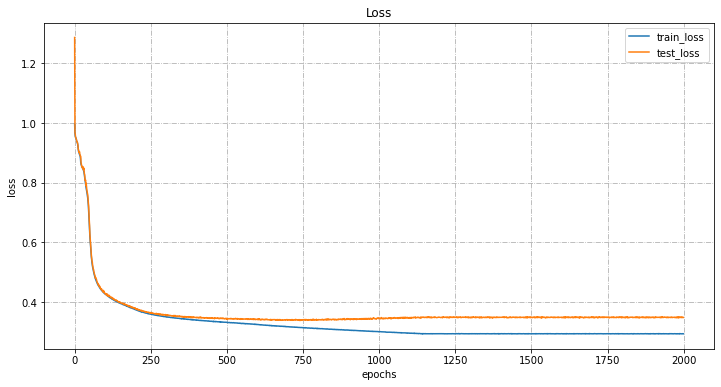

In [14]:
# Plot training history.
performance_log = utils.load_pickle(log_path)

loss_plot_config = utils.LOSS_PLOT_CONFIG.copy()
loss_plot_config['figsize'] = (12, 6)
loss_plot_config['save_dir'] = os.path.join(save_dir, 'loss.png')
loss_plot_config['show_img'] = True
loss_plot_config['xlabel'] = 'epochs'
loss_plot_config['labels'] = ['train_loss', 'test_loss']
data_list = [performance_log['train_loss'], performance_log['test_loss']]
utils.save_plot(data_list, loss_plot_config)

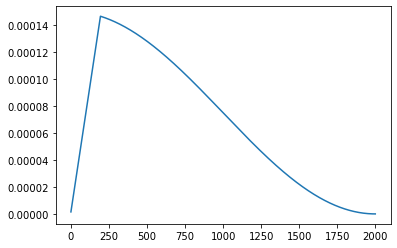

In [15]:
import matplotlib.pyplot as plt

plt.plot(performance_log['lr'])

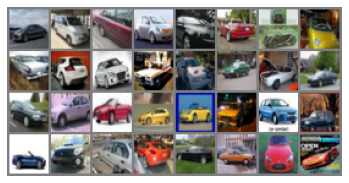

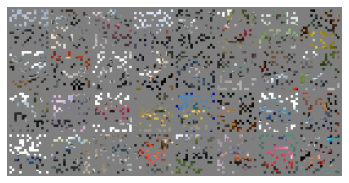

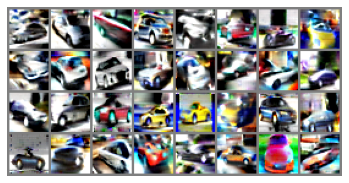

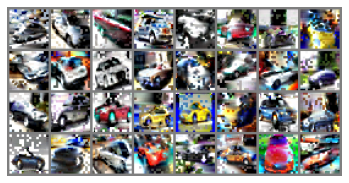

In [16]:
mae_model.eval()
start_idx = random.randint(0, 10000) 
end_idx = start_idx + 32
with torch.no_grad():
    x = torch.stack([test_dataset[i] for i in range(start_idx, end_idx)]).to(device)
    x_pred, loss_mask = mae_model(x)
    masked_x = x * (1 - loss_mask)
    reconstructed_x = x * (1 - loss_mask) + x_pred * loss_mask
    
    utils.show_img_tensor(torchvision.utils.make_grid(x))
    utils.show_img_tensor(torchvision.utils.make_grid(masked_x))
    utils.show_img_tensor(torchvision.utils.make_grid(x_pred))
    utils.show_img_tensor(torchvision.utils.make_grid(reconstructed_x))

In [17]:
# from IPython.core.display import HTML
# HTML("<script>Jupyter.notebook.kernel.restart()</script>")